In [1]:
### Dependencies

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re

### This notebook is for extracting the data from the original kml file and outputing a JSON that will be easy to use with Google Maps API



In [2]:
## LOAD BLOCK###
#### Load data from kml file exported from Google Earth

file_path = ('data/kml/ballparks.kml') # file path to kml file

with open(file_path) as file:

    xml_data = file.read()



# Initialize soup variables for parsing file
soup = BeautifulSoup(xml_data, 'xml')
folders = soup.Document.Folder
list = soup.Document.Folder.find_all('Folder')

## Create a dataframe to hold the data parsed from xml
df = pd.DataFrame(columns=['field', 'foul', 'fop'])

failed = []


In [3]:
#### EXTRACTION BLOCK ####
#### Extract data from kml file

# Create an empty list to store the rows to append to the DataFrame
rows = []

# Loop through the folders and extract the data
for folder in list:
    try:
        field_name = folder.find('name').text
        foul = folder.find_all('coordinates')[0].text
        fop = folder.find_all('coordinates')[1].text

        row = {
            'field': field_name,
            'foul': foul,
            'fop': fop
        }

        rows.append(row)

    except Exception as e:
        # Add name of folder to a list of failed folders
        failed.append(folder.find('name').text)
        print(f"Error processing folder: {folder.find('name').text}. Error message: {str(e)}")

# Convert the list of rows to a DataFrame
df = pd.DataFrame(rows)

# Print a list of failed folders
print(f"Failed to process {len(failed)} folders: {', '.join(failed)}")


Error processing folder: Progressive Field - Cleveland - MLB. Error message: list index out of range
Failed to process 1 folders: Progressive Field - Cleveland - MLB


In [4]:
# Create a copy of the original DataFrame
df_cleaned = df.copy()

# Remove new line and and space characters from coordinates
df_cleaned = df_cleaned.replace(r'\n','', regex=True) 
df_cleaned = df_cleaned.replace(r'\t','', regex=True) 

# Drop any duplicate rows
df_cleaned = df_cleaned.drop_duplicates(subset=['field'], keep='first')

# Drop any rows with empty fields
df_cleaned = df_cleaned[(df_cleaned != 0).all(1)]

re_mlb = re.compile(r'mlb', re.IGNORECASE)
re_pro = re.compile(r'pro', re.IGNORECASE)
re_college = re.compile(r'college', re.IGNORECASE)
re_youth = re.compile(r'youth', re.IGNORECASE)
re_muni = re.compile(r'muni', re.IGNORECASE)
re_international = re.compile(r'international', re.IGNORECASE)

df_cleaned['level'] = df_cleaned['field'].apply(lambda x: 'mlb' 
        if re_mlb.search(x) else 'pro' 
        if re_pro.search(x) else 'college' 
        if re_college.search(x) else 'youth' 
        if re_youth.search(x) else 'muni' 
        if re_muni.search(x) else 'high_school'
        if re_international.search(x) else 'international')


# Define a dictionary that maps level indicators to levels and size factors
level_dict = {
    'MLB': 'mlb', 
    'pro': 'pro', 
    'college': 'college', 
    'high school': 'high_school',
    
}


# Clean up the 'field' column by removing the level indicator and any trailing '-' characters
df_cleaned['field'] = df_cleaned['field'].str.replace(r'\s*(%s)\s*' % '|'.join(level_dict.keys()), '', regex=True, flags=re.IGNORECASE)
df_cleaned['field'] = df_cleaned['field'].str.replace(r'-\s*$', '', regex=True)


## Rename field column to park_name to avoid confusion down the line
df_cleaned = df_cleaned.rename(columns={'field': 'park_name'})



In [5]:
df_cleaned.head()

## Print the two the headers and two rows of data to a txt file for reference


with open('data/rows.txt', 'w') as f:
    f.write(df_cleaned.iloc[0].to_string())
    f.write(df_cleaned.iloc[1].to_string())
    f.write(df_cleaned.iloc[14].to_string())
    

print(df_cleaned.iloc[15].to_string())


park_name                                           Boston C. 
foul         -71.1603978,42.3443347,0 -71.1591854,42.344397...
fop          -71.1603978,42.3443347,0 -71.16031460000001,42...
level                                                  college


In [6]:
##### Code to clean up polygon data and creat a new home_plate column

def parse_coordinates(coord_string):
    coords = coord_string.split()
    parsed_coords = [tuple(map(float, coord.split(',')[:2])) for coord in coords]
    return parsed_coords

# Create a new column for the home_plate location using the first set of coordinates in the 'fop' column
df_cleaned['home_plate'] = df_cleaned['fop'].apply(lambda x: parse_coordinates(x)[0])

# Apply the parse_coordinates function to the 'foul' and 'fop' columns
df_cleaned['foul'] = df_cleaned['foul'].apply(parse_coordinates)
df_cleaned['fop'] = df_cleaned['fop'].apply(parse_coordinates)


In [7]:
def determine_direction(coordinates):
    num_points = len(coordinates)
    if num_points < 2:
        return "Not enough points"

    # Get the latitude (y-coordinate) values
    latitudes = [point[1] for point in coordinates]

    # Check the change in latitude values
    increasing_latitudes = all(latitudes[i] <= latitudes[i+1] for i in range(num_points-1))
    decreasing_latitudes = all(latitudes[i] >= latitudes[i+1] for i in range(num_points-1))

    if increasing_latitudes:
        return "Left Field"
    elif decreasing_latitudes:
        return "Right Field"
    else:
        return "Collinear"

# Apply the determine_direction function to the 'fop' and 'foul' columns
df_cleaned['fop_direction'] = df_cleaned['fop'].apply(determine_direction)
df_cleaned['foul_direction'] = df_cleaned['foul'].apply(determine_direction)

# Print the updated DataFrame
print(df_cleaned)



                                             park_name  \
0                   Day Air Ballpark - Dayton Dragons    
1                 Parkview Field - Fort Wayne TinCaps    
2                  Classic Park- Lake County Captains    
3                ABC Supply Stadium - Beloit Sky Carp    
4    Veterans Memorial Stadium - Cedar Rapids Kernels    
..                                                 ...   
718                                        Williamston   
719                                               WMU    
720                          Wyoming Godwin Heights HS   
721                                            Yale HS   
722                                Ypsilanti - Lincoln   

                                                  foul  \
0    [(-84.18557, 39.7642091), (-84.1849444, 39.764...   
1    [(-85.1429982, 41.0741133), (-85.1432208, 41.0...   
2    [(-81.4362001, 41.6407581), (-81.4362008, 41.6...   
3    [(-89.0406651, 42.4971349), (-89.0408006, 42.4...   
4    [(-91.68

In [8]:
df_cleaned.head()

## Value counts for the fop_direction column
df_cleaned['fop_direction'].value_counts()

## Value counts for the foul_direction column
# df_cleaned['foul_direction'].value_counts()




Collinear    716
Name: fop_direction, dtype: int64

In [9]:
import numpy as np

def calculate_orientation(coordinates):
    num_points = len(coordinates)
    if num_points < 3:
        return "Not enough points"

    signed_area = 0

    for i in range(num_points):
        x1, y1 = coordinates[i]
        x2, y2 = coordinates[(i + 1) % num_points]
        signed_area += (x2 - x1) * (y2 + y1)

    if signed_area > 0:
        return "Counterclockwise"
    elif signed_area < 0:
        return "Clockwise"
    else:
        return "Collinear"

# Apply the calculate_orientation function to the 'fop' and 'foul' columns
df_cleaned['fop_orientation'] = df_cleaned['fop'].apply(calculate_orientation)
df_cleaned['foul_orientation'] = df_cleaned['foul'].apply(calculate_orientation)

# Print the updated DataFrame
print(df_cleaned)



                                             park_name  \
0                   Day Air Ballpark - Dayton Dragons    
1                 Parkview Field - Fort Wayne TinCaps    
2                  Classic Park- Lake County Captains    
3                ABC Supply Stadium - Beloit Sky Carp    
4    Veterans Memorial Stadium - Cedar Rapids Kernels    
..                                                 ...   
718                                        Williamston   
719                                               WMU    
720                          Wyoming Godwin Heights HS   
721                                            Yale HS   
722                                Ypsilanti - Lincoln   

                                                  foul  \
0    [(-84.18557, 39.7642091), (-84.1849444, 39.764...   
1    [(-85.1429982, 41.0741133), (-85.1432208, 41.0...   
2    [(-81.4362001, 41.6407581), (-81.4362008, 41.6...   
3    [(-89.0406651, 42.4971349), (-89.0408006, 42.4...   
4    [(-91.68

In [10]:
#### Show value counts od orientation columns
print(df_cleaned['fop_orientation'].value_counts())
print(df_cleaned['foul_orientation'].value_counts())

Clockwise           715
Counterclockwise      1
Name: fop_orientation, dtype: int64
Clockwise    716
Name: foul_orientation, dtype: int64


In [11]:
df_cleaned_str = df_cleaned.head().to_string()
print(df_cleaned_str)

# Output the string to a txt file for reference
with open('data/df_cleaned_str.txt', 'w') as f:
    f.write(df_cleaned_str)

    




                                           park_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            foul                                                                    

In [12]:
from shapely.geometry import Polygon
import pyproj


#### Functions to calculate the area of a polygon
def utm_zone_number(lat, lon):
    return int((lon + 180) / 6) + 1

def utm_epsg_code(lat, lon):
    zone_number = utm_zone_number(lat, lon)
    if lat >= 0:
        return 32600 + zone_number
    else:
        return 32700 + zone_number

def calculate_area(coords):
    # Create a Polygon object from the coordinates
    polygon = Polygon(coords)

    # Get the appropriate UTM EPSG code
    epsg_code = utm_epsg_code(*coords[0])

    # Create a transformer for converting coordinates to UTM
    transformer = pyproj.Transformer.from_crs(
        pyproj.CRS("EPSG:4326"),  # WGS 84 (latitude and longitude)
        pyproj.CRS(f"EPSG:{epsg_code}"),  # UTM zone
        always_xy=True
    )

    # Convert the coordinates to UTM
    coords_utm = [transformer.transform(*coord) for coord in coords]

    # Create a Polygon object from the UTM coordinates
    polygon_utm = Polygon(coords_utm)

    # Calculate the area in square meters
    area_sqm = polygon_utm.area

    # Convert the area to square feet (1 square meter = 10.764 square feet)
    area_sqft = area_sqm * 10.764

    return area_sqft


### Call Function and add to dataframe
df_cleaned['foul_area_sqft'] = df_cleaned['foul'].apply(calculate_area)
df_cleaned['fop_area_sqft'] = df_cleaned['fop'].apply(calculate_area)


In [13]:
#### SIMPLE DISTANCE CALCULATION USING GEOPY ####

from geopy.distance import great_circle

def calculate_distances(home_plate, outfield_coords):
    def is_same_point(point1, point2, tolerance=1e-6):
        return abs(point1[0] - point2[0]) < tolerance and abs(point1[1] - point2[1]) < tolerance

    home_plate_lat_lon = (home_plate[1], home_plate[0])
    distances = [
        round(great_circle(home_plate_lat_lon, (coord[1], coord[0])).feet)
        for coord in outfield_coords
        if not is_same_point(home_plate, coord)
    ]
    return distances


In [14]:
### Run Function and add to dataframe

# Calculate distances for each row
df_cleaned['distances'] = df_cleaned.apply(lambda row: calculate_distances(row['home_plate'], row['fop']), axis=1)

# Calculate max, min, and average distances for each row
df_cleaned['max_distance'] = df_cleaned['distances'].apply(max)
df_cleaned['min_distance'] = df_cleaned['distances'].apply(min)
df_cleaned['avg_distance'] = df_cleaned['distances'].apply(lambda distances: sum(distances) / len(distances))


In [15]:
#### Orienting the map to the home plate location ####

### Find the center of the field
def calculate_centroid(coords):
    x_coords = [coord[0] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    centroid_x = sum(x_coords) / len(coords)
    centroid_y = sum(y_coords) / len(coords)
    return (centroid_x, centroid_y)


## Find the bearing between the home plate and the center of the field
import math

def calculate_bearing(point1, point2):
    lat1, lon1 = math.radians(point1[1]), math.radians(point1[0])
    lat2, lon2 = math.radians(point2[1]), math.radians(point2[0])

    d_lon = lon2 - lon1

    x = math.cos(lat2) * math.sin(d_lon)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)

    bearing = math.degrees(math.atan2(x, y))
    bearing = (bearing + 360) % 360  # Normalize the bearing to the range [0, 360)

    return bearing

### Function to classify direction in laymans terms North, South, East, West, ect
def degrees_to_cardinal_direction(degrees):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    index = round(degrees / 45)
    return directions[index]



In [16]:
# Calculate the centroid of the outfield fence coordinates for each row
df_cleaned['fop_centroid'] = df_cleaned['fop'].apply(lambda coords: calculate_centroid(coords[1:]))

# Calculate the bearing between home plate and the centroid for each row
df_cleaned['field_orientation'] = df_cleaned.apply(lambda row: calculate_bearing(row['home_plate'], row['fop_centroid']), axis=1)

# Convert the bearing to a cardinal direction
df_cleaned['field_cardinal_direction'] = df_cleaned['field_orientation'].apply(degrees_to_cardinal_direction)



In [17]:
### Rename the Cleaned Dataframe back to the default name
df = df_cleaned

In [18]:
# ### In the fop, foul and home_plate columns, the coordinates are in the format (longitude, latitude).
# ### This is the opposite of the format that is used in Google Maps, so we need to reverse the order of the coordinates.
# df['fop'] = df['fop'].apply(lambda coords: [(coord[1], coord[0]) for coord in coords])
# df['foul'] = df['foul'].apply(lambda coords: [(coord[1], coord[0]) for coord in coords])
# df['home_plate'] = df['home_plate'].apply(lambda coord: (coord[1], coord[0]))


In [19]:
########### TURNED OFF FOR NOW ###########
##****** Don't need school info. want to test new fields

# #### MATCHING HIGH SCHOOL NAMES TO THE MHSAA DATA #####
# import pandas as pd
# from fuzzywuzzy import fuzz, process

# # Read the enrollment table from MHSAA website - 2022 enrollment
# mhsaa_df = pd.read_csv('data/school_info/mhsaa_enrolment_2022.csv')

# # Select just the high school level
# hs_df = df[df['level'] == 'high_school']
# other_df = df[df['level'] != 'high_school']

# # Set the threshold for the fuzzy match
# threshold = 90

# # Define a function to get the best fuzzy match with the threshold
# def get_best_match(field_name, school_names, threshold):
#     best_match = process.extractOne(field_name, school_names, scorer=fuzz.token_set_ratio)
#     if best_match[1] >= threshold:
#         return best_match[0]
#     return None

# # Apply the function to the 'field' column and store the result in a new 'match' column
# hs_df['match'] = hs_df['field'].apply(lambda x: get_best_match(x, mhsaa_df['school_name'], threshold))

# #### This destroys a bunch of the data, at least every high school outside of michigan
# # Drop rows with no match
# # hs_df = hs_df.dropna(subset=['match'])

# # Lookup the hs_df['match'] in the mhsaa_df and return the columns: 'school_id', 'school_name', 'students', 'division'
# columns_to_extract = ['school_id', 'school_name', 'students', 'division']
# for col in columns_to_extract:
#     hs_df[col] = hs_df['match'].apply(lambda x: mhsaa_df.loc[mhsaa_df['school_name'] == x, col].iloc[0] if not mhsaa_df.loc[mhsaa_df['school_name'] == x, col].empty else None)

# # Merge the hs_df and other_df back together
# merged_df = pd.concat([hs_df, other_df], ignore_index=True)


In [20]:
merged_df = df
merged_df.head()

# Save the merged_df DataFrame as a JSON file
merged_df.to_json('data/default_updated_output.json', orient='records')


In [21]:
# ### Code to create report on the json file structure to be used as a reference later
# import json
# import pandas as pd
# from collections import defaultdict
# from builtins import list, dict

# # Load the JSON data from the file
# with open('data/updated_output_data.json', 'r') as file:
#     data = json.load(file)

# # Analyze the JSON data
# def analyze_structure(data, prefix=''):
#     structure = defaultdict(set)
    
#     if isinstance(data, dict):
#         for key, value in data.items():
#             new_prefix = f'{prefix}.{key}' if prefix else key
#             structure[new_prefix].add(type(value))
#             structure.update(analyze_structure(value, new_prefix))
#     elif isinstance(data, list):
#         for item in data:
#             structure.update(analyze_structure(item, prefix))
    
#     return structure

# # Generate the report
# structure = analyze_structure(data)
# descriptions = {
#     'field_name': 'The name of the baseball field.',
#     'foul': 'A list of coordinates representing the foul territory of the field. (lat, lon)',
#     'fop': 'A list of coordinates representing the fair territory of the field. (lat, lon)',
#     'level': 'The level of the field, e.g., high_school, college, etc.',
#     'home_plate': 'A list of coordinates representing the home plate location on the field. (lat, lon)',
#     'foul_area_sqft': 'The total area of the foul territory in square feet.',
#     'fop_area_sqft': 'The total area of the fair territory in square feet.',
#     'distances': 'A list of distances from home plate to the outfield fence at the vertices of the wall.',
#     'max_distance': 'The maximum distance from home plate to the outfield fence.',
#     'min_distance': 'The minimum distance from home plate to the outfield fence.',
#     'avg_distance': 'The average distance from home plate to the outfield fence.',
#     'fop_centroid': 'A list of coordinates representing the centroid of the fair territory.',
#     'field_orientation': "The angle (in degrees) of the field's orientation, with 0 degrees being North.",
#     'field_cardinal_direction': "The cardinal direction abbreviation (N, S, E, W, NE, NW, SE, SW) representing the field's orientation.",
#     'match': 'The matched school name found using fuzzy matching.',
#     'school_id': 'The unique identifier of the matched school.',
#     'school_name': 'The name of the matched school.',
#     'students': 'The number of students enrolled in the matched school.',
#     'division': 'The athletic division the matched school belongs to.'
# }

# # Replace <filename> with your desired filename without the extension
# filename = "output_data"

# def get_sample_value(data, key):
#     for item in data:
#         if key in item and item[key] is not None:
#             return item[key]
#     return None

# # Generate the report with sample values
# report = pd.DataFrame([(key, ', '.join([t.__name__ for t in types]), descriptions.get(key, ''), get_sample_value(data, key)) 
#                        for key, types in structure.items()],
#                       columns=['Key', 'Data Types', 'Description', 'Sample Value'])

# # Save the report as a CSV file
# report.to_csv(f"{filename}_report.csv", index=False)

# print(report)



START WORK BLOCK 4/28/23

In [22]:
import json

with open('data/default_updated_output.json', 'r') as file:
    data = json.load(file)



In [23]:
# create a function to process the data, counting the orientations and filtering by level.

from collections import defaultdict

def process_data(data, level_filter=None):
    count_by_orientation = defaultdict(int)
    
    for record in data:
        if level_filter is None or record['level'] == level_filter:
            orientation = round(record['field_orientation'])
            count_by_orientation[orientation] += 1

    return count_by_orientation


In [55]:
def create_polar_chart(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 2 * np.pi / num_bins

    # Set plot size
    plt.figure(figsize=(10, 10))

    ax = plt.subplot(111, projection='polar')
    ax.set_theta_offset(np.pi / 2)

    ax.set_facecolor('#808080')
    ###
    # ax.set_yscale('log')

    
    # # Set dark background
    # ax.set_facecolor('#2b2b2b')
    plt.gca().set_rlabel_position(22.5)
    ax.set_ylim(-10, 100)  # Adjust based on max count

    bars = ax.bar(bin_edges[:-1], bin_counts, width=bin_width, bottom=-20)
    


    # Use custom colors and opacity
    for r, bar in zip(bin_counts, bars):
        bar.set_facecolor(plt.cm.viridis(r / max(bin_counts)))
        # bar.set_facecolor(plt.cm.plasma(r / max(bin_counts)))
        bar.set_alpha(0.8)

    plt.show()




In [60]:
### UPDATED GPT CODE - LATE NIGHT FRIDAY


import numpy as np
import matplotlib.pyplot as plt

def create_polar_chart(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 2 * np.pi / num_bins

    # Set plot size
    plt.figure(figsize=(10, 10))

    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2)

    ax.set_facecolor('#808080')
    ###
    # ax.set_yscale('log')

    
    # # Set dark background
    ax.set_facecolor('#2b2b2b')
    plt.gca().set_rlabel_position(22.5)
    ax.set_ylim(-20, 130)  # Adjust based on max count

    # Add bars for negative values
    zero_height_bars = ax.bar(bin_edges[:-1], np.abs(ax.get_ylim()[0]), width=bin_width, bottom=0.0, color='k', alpha=0.3)

    bars = ax.bar(bin_edges[:-1], bin_counts, width=bin_width, bottom=0)
    
    # Use custom colors and opacity
    for r, bar in zip(bin_counts, bars):
        bar.set_facecolor(plt.cm.viridis(r / max(bin_counts)))
        # bar.set_facecolor(plt.cm.plasma(r / max(bin_counts)))
        bar.set_alpha(0.8)

    plt.show()


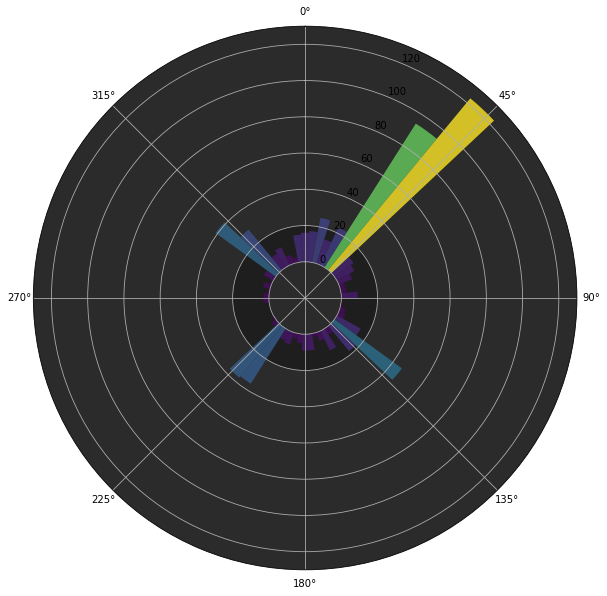

In [66]:
create_polar_chart(data, num_bins=50, level_filter=None)


#### GOAL
## fill the center portion of the plot to create a heat map of the field orientations



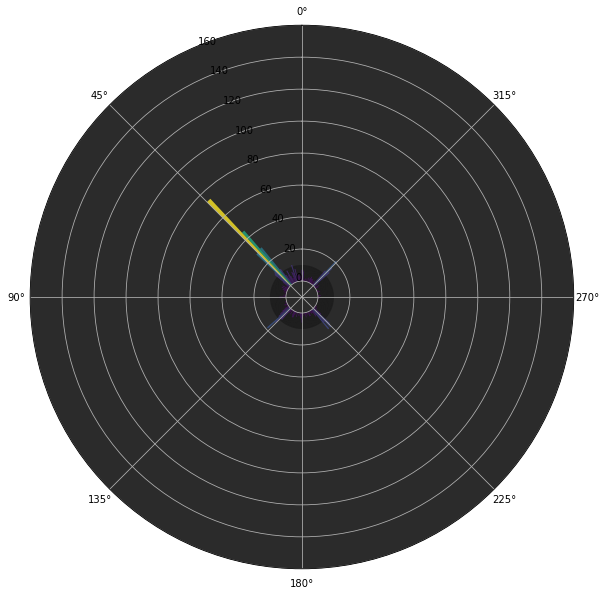

In [27]:
create_polar_chart(data, num_bins=180, level_filter=None)


In [28]:
### HEATMAP CODE

import numpy as np
import matplotlib.pyplot as plt

def create_heatmap(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)

    # Compute the histogram
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
    bin_counts = np.zeros(num_bins)

    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count

    # Reshape histogram data into a 2D array
    heatmap_data = np.tile(bin_counts, (num_bins, 1))

    # Set plot size
    plt.figure(figsize=(10, 10))

    # Create heatmap
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto', interpolation='nearest', origin='lower')
    plt.colorbar(label='Counts')

    # Set x-axis ticks and labels
    plt.xticks(np.arange(0, num_bins, num_bins // 6), np.arange(0, 361, 60))
    plt.xlabel('Orientation (degrees)')

    # Set y-axis ticks and labels (assuming equal radial divisions)
    max_radius_label = 'Max Radius'
    plt.yticks(np.arange(0, num_bins, num_bins // 6), [0, 1, 2, 3, 4, max_radius_label])
    plt.ylabel('Radial Division')

    plt.show()

# Example usage:
# create_heatmap(data)


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (7).

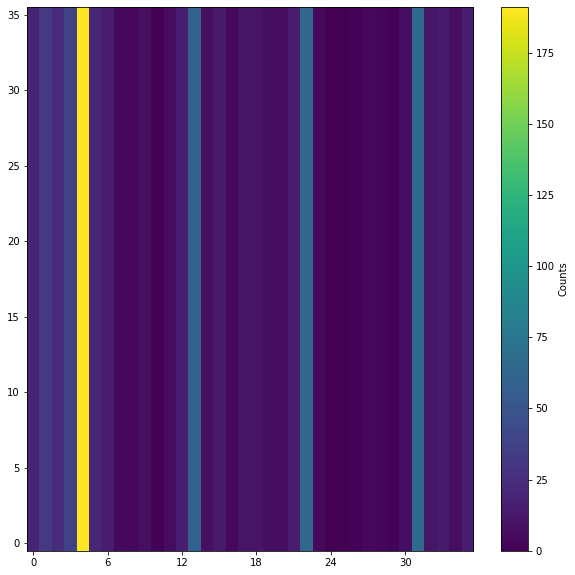

In [29]:
# Example usage:
create_heatmap(data)

In [ ]:
# ### EXAMPLE# CODE FROM MATPLOTLIB GALLERY
# =======================
# Pie chart on polar axis
# =======================

# Demo of bar plot on a polar axis.
# """
# import numpy as np
# import matplotlib.pyplot as plt


# # Compute pie slices
# N = 20
# theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
# radii = 10 * np.random.rand(N)
# width = np.pi / 4 * np.random.rand(N)

# ax = plt.subplot(111, projection='polar')
# bars = ax.bar(theta, radii, width=width, bottom=0.0)

# # Use custom colors and opacity
# for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.viridis(r / 10.))
#     bar.set_alpha(0.5)

# plt.show()

In [37]:
### Plot a histogram of the field orientations for all levels

import numpy as np
import matplotlib.pyplot as plt

def create_histogram(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 360.0, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 360 / num_bins

    # Plot the histogram
    fig, ax = plt.subplots()
    ax.bar(bin_edges[:-1], bin_counts, width=bin_width, edgecolor='black')
    ax.set_xlabel('Field Orientation (degrees)')
    ax.set_ylabel('Number of Fields')
    ax.set_title('Field Orientation Histogram')

    # Set the major tick locations
    major_tick_locations = [45, 135, 225, 315]
    plt.xticks(major_tick_locations, major_tick_locations)


    
    plt.show()


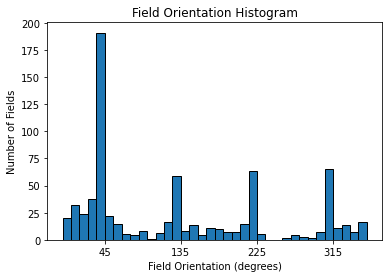

In [38]:
create_histogram(data, num_bins=36, level_filter=None)

END WORK BLOCK

In [34]:
df['field_cardinal_direction'].value_counts()

NE    279
SE    100
NW     96
SW     88
N      84
S      36
E      22
W      11
Name: field_cardinal_direction, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
# Rename the dataframe back to the default name
df = merged_df

# Set the plot size
plt.figure(figsize=(10, 6))

# Create the scatter plot
plt.scatter(df_cleaned['min_distance'], df_cleaned['max_distance'], alpha=0.8)

# Customize the plot
plt.xlabel('Min Distance (feet)')
plt.ylabel('Max Distance (feet)')
plt.title('Scatter Plot of Min and Max Distances to Outfield Fence')

# Display the plot in the Jupyter Notebook
plt.show()


In [ ]:
##### CODE TO MAKE A LIST OF OUTLIERS #####

# Filter the DataFrame for fields with min distances below 100 feet
outliers = df[df['min_distance'] < 100]

# Display the outlier fields in the Jupyter Notebook
print(outliers[['park_name', 'min_distance', 'max_distance']])

# Save the outlier fields to a CSV file
outliers.to_csv('outlier_fields.csv', index=False)



In [ ]:
len(outliers)

In [ ]:
df.head()